In [134]:
using Images
using FFTW
using Random
using Plots

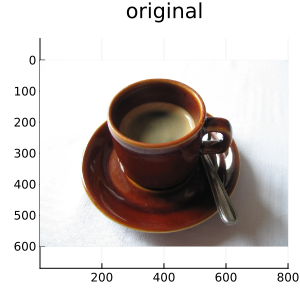

In [135]:
# Load image
A = load("photo.jpeg")

plot(A, size=(300, 300), title="original")

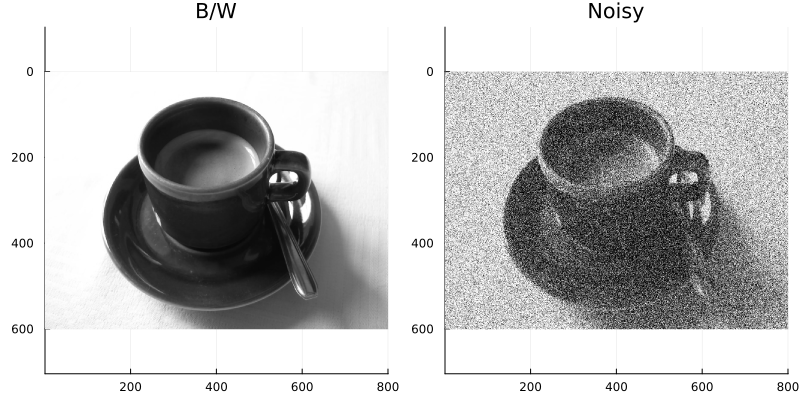

In [136]:
# Add noise to create B for each color channel
noise_level = 0.5

# Convert to grayscale
Abw = Gray.(A)

# Add noise to create B
B = Abw .+ noise_level * randn(size(Abw))

# Display the original, the B/W and noisy images
plot(size=(800, 400), layout=(1,2), titles=["B/W" "Noisy"])
plot!(Abw, subplot = 1)
plot!(B, subplot = 2)

In [137]:
# Perform 2D FFT for each color channel
Abw_fft = fft(Float64.(Abw), [1,2])

# Shift zero frequency components to the center
Abw_fft_shifted = fftshift(Abw_fft);

In [138]:
# Perform 2D FFT for each color channel
B_fft = fft(Float64.(B), [1,2])

# Shift zero frequency components to the center
B_fft_shifted = fftshift(B_fft);

In [139]:
# Plot the FFT magnitudes
plot(
     heatmap(log.(abs.(Abw_fft_shifted)), title="FFT Magnitude - B/W")
    ,heatmap(log.(abs.(B_fft_shifted)), title="FFT Magnitude - Noisy")
    ,layout=(1,2)
    ,size=(800, 400)
)

# References
- [ ] [I succeeded to 2d FFT of image. But](https://discourse.julialang.org/t/i-succeeded-to-2d-fft-of-image-but/22404)

In [140]:
using DSP, FFTW, Plots

In [141]:
import DSP.freqz

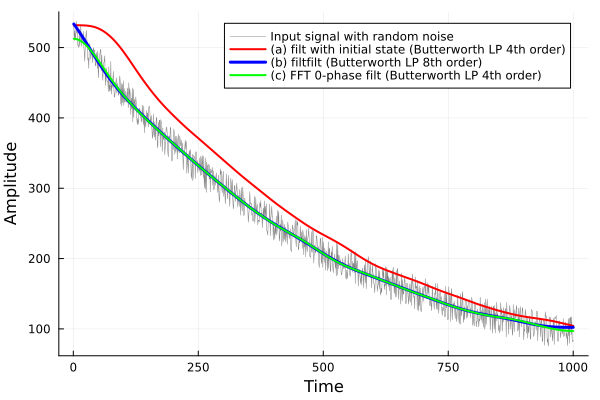

In [142]:
N = 1000; t = 1:N; fs = 1/5; f0 = 1/750   # sampling and cutoff frequencies
y = 500*(exp.(-t/500) .+ 0.1*rand(length(t)))  # noisy input y
lpfilt = digitalfilter(Lowpass(f0, fs=fs), Butterworth(4))

# (a) filt with initial state by @sairus7
b, a = coefb(lpfilt), coefa(lpfilt)
order = 4
s0 = zeros(order)
s0[order] = b[order + 1] - a[order + 1]
for k in order:-1:2
    s0[k - 1] = b[k] - a[k] + s0[k]
end
s0 *= y[1]
y_filt0 = filt(b, a, y, s0)

# (b) filtfilt
y_filt1 = filtfilt(lpfilt,y)

# (c) rg's FFT 0-phase filter
y2 = [y[end:-1:1]; y]   # make real input symmetric around t=0
f0 = fftshift(LinRange(-fs/2,fs/2,2N+1)[1:2N])
Hf = abs.(freqz(lpfilt,f0,fs)) .* fft(y2)
y_filt2 = real.((ifft(Hf)))[N+1:end]

plot(y2[N+1:end], lw=0.5, lc=:grey, xl="Time", label="Input signal with random noise")
plot!(y_filt0, lc=:red, lw=2,label="(a) filt with initial state (Butterworth LP 4th order)")
plot!(y_filt1, lc=:blue, lw=3, yl="Amplitude", label="(b) filtfilt (Butterworth LP 8th order)")
plot!(y_filt2, lc=:lime, lw=2,label="(c) FFT 0-phase filt (Butterworth LP 4th order)")